# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [24]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

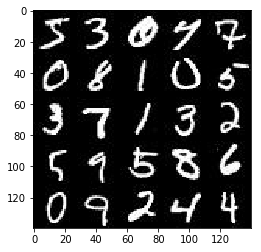

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

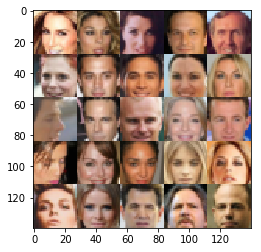

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/nbhad/anaconda/envs/face-generation/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_image = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_image')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')

    return input_image, z_input, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding="same")
        relu1 = tf.maximum( 0.2 * x1, x1 )
        
        x2 = tf.layers.conv2d(relu1, 112, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum( 0.2 * bn2, bn2 )
        
        x3 = tf.layers.conv2d(relu2, 224, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum( 0.2 * bn3, bn3 )
        
        flat = tf.reshape(relu3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse=True
    if(is_train):
        reuse=False
    
    with tf.variable_scope("generator", reuse=reuse):
        x1 = tf.layers.dense(z, 2*2*224)
        x1 = tf.reshape(x1, (-1, 2, 2, 224))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1 * 0.2, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 112, 5, strides=2)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2 * 0.2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 56, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3 * 0.2, x3)
        
        
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake 
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_image, z_input, learn_rate = model_inputs(data_shape[1], data_shape[2],data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_image, z_input, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    sample_z = tf.random_uniform((72, z_dim), -1, 1)
    
    samples, losses = [], []
    steps = 0

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1 
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_image: batch_images, z_input: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, input_image: batch_images, learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, input_image: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 72, sample_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2228... Generator Loss: 2.0925
Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 0.5098
Epoch 1/2... Discriminator Loss: 0.2818... Generator Loss: 2.0508
Epoch 1/2... Discriminator Loss: 1.9878... Generator Loss: 0.2214
Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 5.3307
Epoch 1/2... Discriminator Loss: 0.3648... Generator Loss: 2.0721
Epoch 1/2... Discriminator Loss: 0.3678... Generator Loss: 2.0347
Epoch 1/2... Discriminator Loss: 0.1935... Generator Loss: 2.5368
Epoch 1/2... Discriminator Loss: 0.2169... Generator Loss: 2.5381
Epoch 1/2... Discriminator Loss: 0.1374... Generator Loss: 2.7720


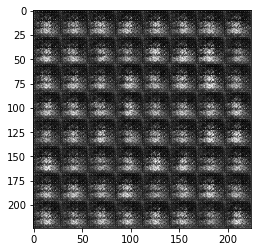

Epoch 1/2... Discriminator Loss: 0.2618... Generator Loss: 1.9600
Epoch 1/2... Discriminator Loss: 0.0791... Generator Loss: 3.8452
Epoch 1/2... Discriminator Loss: 0.0816... Generator Loss: 3.4994
Epoch 1/2... Discriminator Loss: 0.1062... Generator Loss: 3.2597
Epoch 1/2... Discriminator Loss: 0.1152... Generator Loss: 2.7794
Epoch 1/2... Discriminator Loss: 0.0918... Generator Loss: 3.5611
Epoch 1/2... Discriminator Loss: 0.3282... Generator Loss: 6.1806
Epoch 1/2... Discriminator Loss: 0.1673... Generator Loss: 8.8856
Epoch 1/2... Discriminator Loss: 0.0946... Generator Loss: 3.4759
Epoch 1/2... Discriminator Loss: 0.1429... Generator Loss: 2.9011


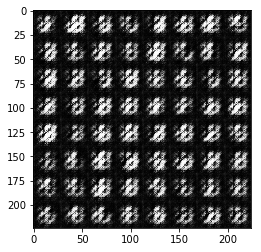

Epoch 1/2... Discriminator Loss: 0.2146... Generator Loss: 2.5320
Epoch 1/2... Discriminator Loss: 0.5414... Generator Loss: 4.0433
Epoch 1/2... Discriminator Loss: 0.8596... Generator Loss: 1.1556
Epoch 1/2... Discriminator Loss: 0.1978... Generator Loss: 2.6806
Epoch 1/2... Discriminator Loss: 0.1898... Generator Loss: 2.7467
Epoch 1/2... Discriminator Loss: 0.2412... Generator Loss: 2.1423
Epoch 1/2... Discriminator Loss: 0.1307... Generator Loss: 3.3651
Epoch 1/2... Discriminator Loss: 0.1395... Generator Loss: 3.2901
Epoch 1/2... Discriminator Loss: 0.1842... Generator Loss: 2.5516
Epoch 1/2... Discriminator Loss: 0.1573... Generator Loss: 2.8437


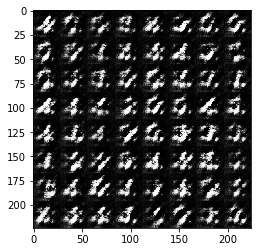

Epoch 1/2... Discriminator Loss: 0.1056... Generator Loss: 4.3643
Epoch 1/2... Discriminator Loss: 0.2275... Generator Loss: 2.3169
Epoch 1/2... Discriminator Loss: 0.2340... Generator Loss: 2.3099
Epoch 1/2... Discriminator Loss: 0.8465... Generator Loss: 7.5515
Epoch 1/2... Discriminator Loss: 0.1849... Generator Loss: 3.7497
Epoch 1/2... Discriminator Loss: 0.2037... Generator Loss: 2.8215
Epoch 1/2... Discriminator Loss: 0.6405... Generator Loss: 4.3223
Epoch 1/2... Discriminator Loss: 0.2656... Generator Loss: 2.8106
Epoch 1/2... Discriminator Loss: 1.8437... Generator Loss: 0.4342
Epoch 1/2... Discriminator Loss: 1.3560... Generator Loss: 0.4838


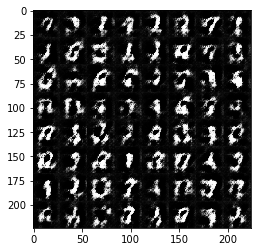

Epoch 1/2... Discriminator Loss: 0.3252... Generator Loss: 2.4171
Epoch 1/2... Discriminator Loss: 0.3954... Generator Loss: 3.5123
Epoch 1/2... Discriminator Loss: 0.2636... Generator Loss: 3.1092
Epoch 1/2... Discriminator Loss: 0.5671... Generator Loss: 1.4349
Epoch 1/2... Discriminator Loss: 0.2816... Generator Loss: 2.5215
Epoch 1/2... Discriminator Loss: 0.2938... Generator Loss: 2.4275
Epoch 1/2... Discriminator Loss: 1.1333... Generator Loss: 0.9493
Epoch 1/2... Discriminator Loss: 0.3256... Generator Loss: 3.1378
Epoch 1/2... Discriminator Loss: 0.4757... Generator Loss: 1.5909
Epoch 1/2... Discriminator Loss: 0.3520... Generator Loss: 1.8114


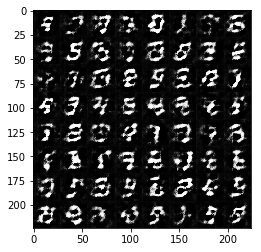

Epoch 1/2... Discriminator Loss: 0.2892... Generator Loss: 2.1986
Epoch 1/2... Discriminator Loss: 0.3995... Generator Loss: 3.0601
Epoch 1/2... Discriminator Loss: 0.6112... Generator Loss: 4.8863
Epoch 1/2... Discriminator Loss: 0.3224... Generator Loss: 2.6192
Epoch 1/2... Discriminator Loss: 0.8841... Generator Loss: 5.2778
Epoch 1/2... Discriminator Loss: 0.5239... Generator Loss: 3.2397
Epoch 1/2... Discriminator Loss: 0.5680... Generator Loss: 1.4353
Epoch 1/2... Discriminator Loss: 0.4024... Generator Loss: 1.8800
Epoch 1/2... Discriminator Loss: 0.2769... Generator Loss: 2.6373
Epoch 1/2... Discriminator Loss: 0.3347... Generator Loss: 2.2022


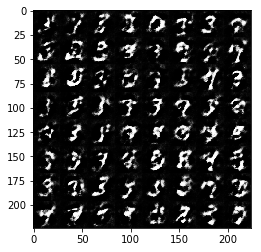

Epoch 1/2... Discriminator Loss: 0.3103... Generator Loss: 3.1341
Epoch 1/2... Discriminator Loss: 0.3107... Generator Loss: 3.4474
Epoch 1/2... Discriminator Loss: 0.4421... Generator Loss: 2.2730
Epoch 1/2... Discriminator Loss: 0.2414... Generator Loss: 3.1637
Epoch 1/2... Discriminator Loss: 0.5107... Generator Loss: 1.5712
Epoch 1/2... Discriminator Loss: 0.2839... Generator Loss: 2.3454
Epoch 1/2... Discriminator Loss: 0.6023... Generator Loss: 1.1109
Epoch 1/2... Discriminator Loss: 0.4724... Generator Loss: 1.6211
Epoch 1/2... Discriminator Loss: 0.2336... Generator Loss: 2.8950
Epoch 1/2... Discriminator Loss: 0.4852... Generator Loss: 1.4543


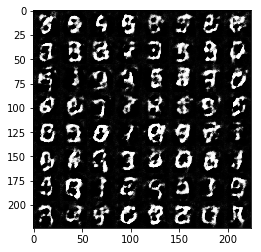

Epoch 1/2... Discriminator Loss: 0.5052... Generator Loss: 1.5351
Epoch 1/2... Discriminator Loss: 0.3387... Generator Loss: 2.6662
Epoch 1/2... Discriminator Loss: 0.2761... Generator Loss: 1.9638
Epoch 1/2... Discriminator Loss: 0.3509... Generator Loss: 3.5042
Epoch 1/2... Discriminator Loss: 0.3603... Generator Loss: 1.6184
Epoch 1/2... Discriminator Loss: 0.2174... Generator Loss: 2.5154
Epoch 1/2... Discriminator Loss: 0.3116... Generator Loss: 2.1283
Epoch 1/2... Discriminator Loss: 0.9201... Generator Loss: 0.7558
Epoch 1/2... Discriminator Loss: 0.6476... Generator Loss: 1.0892
Epoch 1/2... Discriminator Loss: 0.3927... Generator Loss: 2.0823


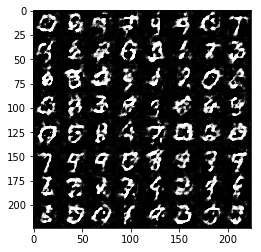

Epoch 1/2... Discriminator Loss: 0.2712... Generator Loss: 2.1189
Epoch 1/2... Discriminator Loss: 0.9604... Generator Loss: 5.4430
Epoch 1/2... Discriminator Loss: 0.2570... Generator Loss: 2.2329
Epoch 1/2... Discriminator Loss: 0.2759... Generator Loss: 2.1273
Epoch 1/2... Discriminator Loss: 0.3545... Generator Loss: 1.6301
Epoch 1/2... Discriminator Loss: 2.3869... Generator Loss: 0.2352
Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 3.8480
Epoch 1/2... Discriminator Loss: 0.3603... Generator Loss: 2.3059
Epoch 1/2... Discriminator Loss: 0.3664... Generator Loss: 2.6260
Epoch 1/2... Discriminator Loss: 0.3203... Generator Loss: 2.0372


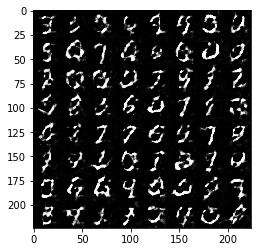

Epoch 1/2... Discriminator Loss: 0.6099... Generator Loss: 1.1894
Epoch 1/2... Discriminator Loss: 0.3050... Generator Loss: 2.0891
Epoch 1/2... Discriminator Loss: 0.3459... Generator Loss: 2.1179
Epoch 2/2... Discriminator Loss: 0.4881... Generator Loss: 1.5640
Epoch 2/2... Discriminator Loss: 0.3428... Generator Loss: 2.4194
Epoch 2/2... Discriminator Loss: 0.3425... Generator Loss: 2.1085
Epoch 2/2... Discriminator Loss: 0.5416... Generator Loss: 2.4738
Epoch 2/2... Discriminator Loss: 0.3408... Generator Loss: 1.8153
Epoch 2/2... Discriminator Loss: 0.4884... Generator Loss: 1.8277
Epoch 2/2... Discriminator Loss: 0.4096... Generator Loss: 1.5920


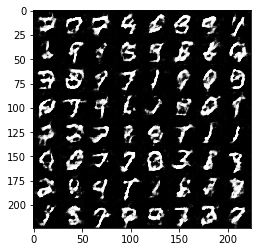

Epoch 2/2... Discriminator Loss: 0.4372... Generator Loss: 1.9759
Epoch 2/2... Discriminator Loss: 0.2230... Generator Loss: 2.5879
Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 3.0058
Epoch 2/2... Discriminator Loss: 0.5619... Generator Loss: 1.1912
Epoch 2/2... Discriminator Loss: 0.3273... Generator Loss: 2.7406
Epoch 2/2... Discriminator Loss: 0.4320... Generator Loss: 2.4729
Epoch 2/2... Discriminator Loss: 0.4279... Generator Loss: 1.6881
Epoch 2/2... Discriminator Loss: 0.5973... Generator Loss: 1.1412
Epoch 2/2... Discriminator Loss: 0.4016... Generator Loss: 2.1985
Epoch 2/2... Discriminator Loss: 0.7348... Generator Loss: 1.0225


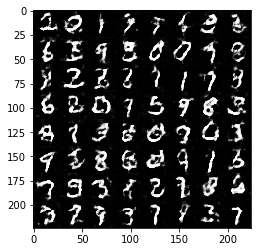

Epoch 2/2... Discriminator Loss: 0.2777... Generator Loss: 3.0963
Epoch 2/2... Discriminator Loss: 0.3693... Generator Loss: 2.2980
Epoch 2/2... Discriminator Loss: 0.3459... Generator Loss: 2.3117
Epoch 2/2... Discriminator Loss: 0.3313... Generator Loss: 2.8506
Epoch 2/2... Discriminator Loss: 0.7189... Generator Loss: 0.9666
Epoch 2/2... Discriminator Loss: 0.4437... Generator Loss: 1.6062
Epoch 2/2... Discriminator Loss: 0.4105... Generator Loss: 2.9763
Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 0.6263
Epoch 2/2... Discriminator Loss: 0.3713... Generator Loss: 2.0200
Epoch 2/2... Discriminator Loss: 0.2451... Generator Loss: 2.4760


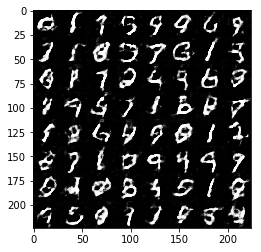

Epoch 2/2... Discriminator Loss: 0.4258... Generator Loss: 2.0533
Epoch 2/2... Discriminator Loss: 0.3595... Generator Loss: 1.8831
Epoch 2/2... Discriminator Loss: 0.5510... Generator Loss: 1.4787
Epoch 2/2... Discriminator Loss: 0.4828... Generator Loss: 1.5273
Epoch 2/2... Discriminator Loss: 0.5439... Generator Loss: 2.4046
Epoch 2/2... Discriminator Loss: 1.0444... Generator Loss: 0.6990
Epoch 2/2... Discriminator Loss: 0.4846... Generator Loss: 1.3937
Epoch 2/2... Discriminator Loss: 0.4402... Generator Loss: 2.7876
Epoch 2/2... Discriminator Loss: 0.6373... Generator Loss: 1.0758
Epoch 2/2... Discriminator Loss: 0.4335... Generator Loss: 2.2787


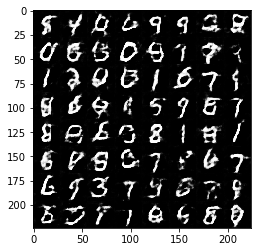

Epoch 2/2... Discriminator Loss: 0.3578... Generator Loss: 2.1825
Epoch 2/2... Discriminator Loss: 0.7197... Generator Loss: 2.9125
Epoch 2/2... Discriminator Loss: 0.7135... Generator Loss: 3.9334
Epoch 2/2... Discriminator Loss: 0.5213... Generator Loss: 3.2187
Epoch 2/2... Discriminator Loss: 0.5280... Generator Loss: 1.7855
Epoch 2/2... Discriminator Loss: 0.6536... Generator Loss: 1.0610
Epoch 2/2... Discriminator Loss: 0.3711... Generator Loss: 1.8439
Epoch 2/2... Discriminator Loss: 0.2956... Generator Loss: 1.8319
Epoch 2/2... Discriminator Loss: 0.2345... Generator Loss: 2.2489
Epoch 2/2... Discriminator Loss: 1.7777... Generator Loss: 0.3466


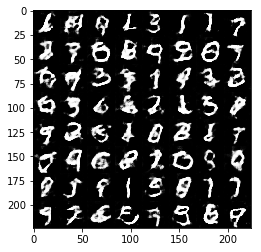

Epoch 2/2... Discriminator Loss: 0.5128... Generator Loss: 1.4476
Epoch 2/2... Discriminator Loss: 0.4707... Generator Loss: 1.5404
Epoch 2/2... Discriminator Loss: 0.4528... Generator Loss: 1.4709
Epoch 2/2... Discriminator Loss: 0.3259... Generator Loss: 1.9921
Epoch 2/2... Discriminator Loss: 0.3725... Generator Loss: 1.7898
Epoch 2/2... Discriminator Loss: 0.5784... Generator Loss: 1.1214
Epoch 2/2... Discriminator Loss: 0.3684... Generator Loss: 1.9169
Epoch 2/2... Discriminator Loss: 0.3456... Generator Loss: 1.8823
Epoch 2/2... Discriminator Loss: 0.2775... Generator Loss: 2.3098
Epoch 2/2... Discriminator Loss: 0.4340... Generator Loss: 1.4500


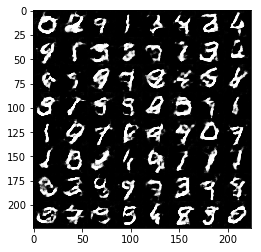

Epoch 2/2... Discriminator Loss: 0.5579... Generator Loss: 1.0960
Epoch 2/2... Discriminator Loss: 0.2928... Generator Loss: 2.2189
Epoch 2/2... Discriminator Loss: 0.3169... Generator Loss: 2.4604
Epoch 2/2... Discriminator Loss: 0.2560... Generator Loss: 2.3380
Epoch 2/2... Discriminator Loss: 0.3618... Generator Loss: 1.8907
Epoch 2/2... Discriminator Loss: 0.3084... Generator Loss: 2.2484
Epoch 2/2... Discriminator Loss: 0.6615... Generator Loss: 1.1377
Epoch 2/2... Discriminator Loss: 0.4608... Generator Loss: 1.5069
Epoch 2/2... Discriminator Loss: 0.6225... Generator Loss: 1.1875
Epoch 2/2... Discriminator Loss: 0.2902... Generator Loss: 2.0670


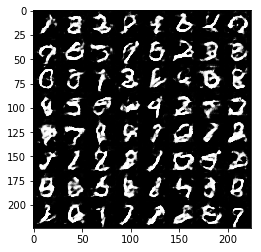

Epoch 2/2... Discriminator Loss: 0.5977... Generator Loss: 1.0985
Epoch 2/2... Discriminator Loss: 1.0295... Generator Loss: 0.9027
Epoch 2/2... Discriminator Loss: 1.3679... Generator Loss: 0.4656
Epoch 2/2... Discriminator Loss: 0.4510... Generator Loss: 2.0314
Epoch 2/2... Discriminator Loss: 0.3836... Generator Loss: 1.9347
Epoch 2/2... Discriminator Loss: 0.3348... Generator Loss: 1.7297
Epoch 2/2... Discriminator Loss: 0.2757... Generator Loss: 2.0039
Epoch 2/2... Discriminator Loss: 0.2908... Generator Loss: 1.9471
Epoch 2/2... Discriminator Loss: 0.2552... Generator Loss: 2.0766
Epoch 2/2... Discriminator Loss: 0.4167... Generator Loss: 1.4822


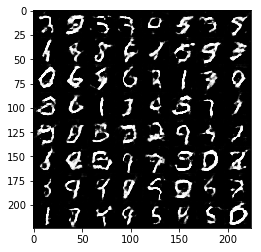

Epoch 2/2... Discriminator Loss: 0.3159... Generator Loss: 2.0218
Epoch 2/2... Discriminator Loss: 0.5395... Generator Loss: 1.2516
Epoch 2/2... Discriminator Loss: 0.8459... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 0.3559... Generator Loss: 1.8345
Epoch 2/2... Discriminator Loss: 0.3264... Generator Loss: 2.6435
Epoch 2/2... Discriminator Loss: 0.2431... Generator Loss: 2.2678
Epoch 2/2... Discriminator Loss: 0.3740... Generator Loss: 1.5590
Epoch 2/2... Discriminator Loss: 0.2739... Generator Loss: 2.2744
Epoch 2/2... Discriminator Loss: 0.1273... Generator Loss: 3.3644
Epoch 2/2... Discriminator Loss: 2.3850... Generator Loss: 0.1562


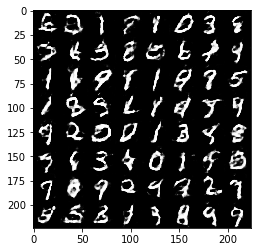

Epoch 2/2... Discriminator Loss: 0.6647... Generator Loss: 0.9679
Epoch 2/2... Discriminator Loss: 0.7384... Generator Loss: 1.0513
Epoch 2/2... Discriminator Loss: 0.3117... Generator Loss: 1.7845
Epoch 2/2... Discriminator Loss: 0.3576... Generator Loss: 1.9114
Epoch 2/2... Discriminator Loss: 0.3219... Generator Loss: 2.0746
Epoch 2/2... Discriminator Loss: 0.3298... Generator Loss: 1.8499
Epoch 2/2... Discriminator Loss: 0.2458... Generator Loss: 2.2082


In [33]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2784... Generator Loss: 1.9675
Epoch 1/1... Discriminator Loss: 0.1440... Generator Loss: 2.5093
Epoch 1/1... Discriminator Loss: 0.3363... Generator Loss: 1.5355
Epoch 1/1... Discriminator Loss: 0.2980... Generator Loss: 1.6324
Epoch 1/1... Discriminator Loss: 0.2349... Generator Loss: 13.3347
Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 12.4879
Epoch 1/1... Discriminator Loss: 0.3216... Generator Loss: 8.4560
Epoch 1/1... Discriminator Loss: 0.2953... Generator Loss: 2.8531
Epoch 1/1... Discriminator Loss: 0.0977... Generator Loss: 3.6906
Epoch 1/1... Discriminator Loss: 0.2992... Generator Loss: 1.8878


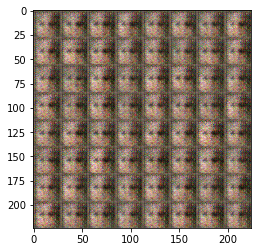

Epoch 1/1... Discriminator Loss: 0.1825... Generator Loss: 3.4508
Epoch 1/1... Discriminator Loss: 0.4453... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 0.1899... Generator Loss: 3.1582
Epoch 1/1... Discriminator Loss: 0.1761... Generator Loss: 2.6131
Epoch 1/1... Discriminator Loss: 0.1983... Generator Loss: 3.6398
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 1.5788
Epoch 1/1... Discriminator Loss: 0.2705... Generator Loss: 2.6483
Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 1.4052
Epoch 1/1... Discriminator Loss: 0.2847... Generator Loss: 2.6595
Epoch 1/1... Discriminator Loss: 0.3481... Generator Loss: 1.8412


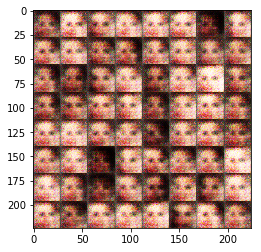

Epoch 1/1... Discriminator Loss: 0.2714... Generator Loss: 3.2376
Epoch 1/1... Discriminator Loss: 0.3691... Generator Loss: 4.2317
Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 4.1470
Epoch 1/1... Discriminator Loss: 0.2226... Generator Loss: 3.3594
Epoch 1/1... Discriminator Loss: 0.2496... Generator Loss: 2.3329
Epoch 1/1... Discriminator Loss: 0.2735... Generator Loss: 2.7408
Epoch 1/1... Discriminator Loss: 0.3639... Generator Loss: 1.6008
Epoch 1/1... Discriminator Loss: 0.2254... Generator Loss: 1.9351
Epoch 1/1... Discriminator Loss: 0.2102... Generator Loss: 3.8755
Epoch 1/1... Discriminator Loss: 0.2279... Generator Loss: 2.6745


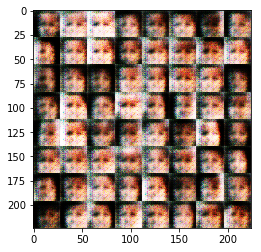

Epoch 1/1... Discriminator Loss: 0.2945... Generator Loss: 3.2808
Epoch 1/1... Discriminator Loss: 0.3935... Generator Loss: 6.2186
Epoch 1/1... Discriminator Loss: 0.2175... Generator Loss: 2.9342
Epoch 1/1... Discriminator Loss: 0.2382... Generator Loss: 2.0312
Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 6.5557
Epoch 1/1... Discriminator Loss: 0.2406... Generator Loss: 2.4367
Epoch 1/1... Discriminator Loss: 0.2026... Generator Loss: 2.4787
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 1.3560
Epoch 1/1... Discriminator Loss: 0.3743... Generator Loss: 1.8541
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 1.4850


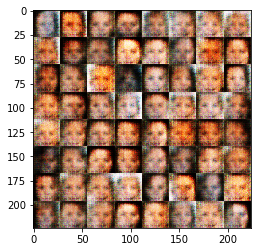

Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 5.3028
Epoch 1/1... Discriminator Loss: 0.2449... Generator Loss: 2.8825
Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 2.9691
Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 3.4147
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 0.4173... Generator Loss: 1.6220
Epoch 1/1... Discriminator Loss: 0.3042... Generator Loss: 1.9525
Epoch 1/1... Discriminator Loss: 0.4366... Generator Loss: 2.3965
Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 4.2764


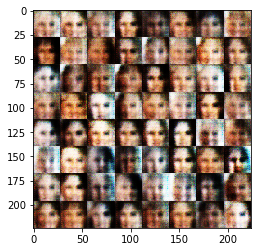

Epoch 1/1... Discriminator Loss: 0.5454... Generator Loss: 1.2459
Epoch 1/1... Discriminator Loss: 0.3856... Generator Loss: 1.5949
Epoch 1/1... Discriminator Loss: 0.3386... Generator Loss: 3.3814
Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 1.1438
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 1.6829
Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 2.7900
Epoch 1/1... Discriminator Loss: 0.4135... Generator Loss: 2.7671
Epoch 1/1... Discriminator Loss: 0.4099... Generator Loss: 1.5158
Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 2.6519
Epoch 1/1... Discriminator Loss: 0.2397... Generator Loss: 3.8095


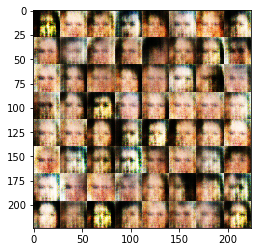

Epoch 1/1... Discriminator Loss: 0.5858... Generator Loss: 1.8037
Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 1.6423
Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 0.4331... Generator Loss: 2.1576
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 3.3223
Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 1.4399
Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 2.5516
Epoch 1/1... Discriminator Loss: 0.5188... Generator Loss: 1.8008


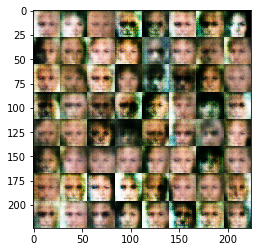

Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.1920
Epoch 1/1... Discriminator Loss: 0.5628... Generator Loss: 1.4153
Epoch 1/1... Discriminator Loss: 0.6182... Generator Loss: 1.0826
Epoch 1/1... Discriminator Loss: 0.5012... Generator Loss: 1.3628
Epoch 1/1... Discriminator Loss: 0.4757... Generator Loss: 2.9213
Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 2.3263
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 3.4179
Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 2.6951
Epoch 1/1... Discriminator Loss: 0.6119... Generator Loss: 1.3876
Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 1.4414


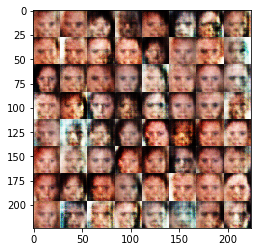

Epoch 1/1... Discriminator Loss: 0.5160... Generator Loss: 1.3266
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 0.4952... Generator Loss: 2.0640
Epoch 1/1... Discriminator Loss: 0.3879... Generator Loss: 2.2585
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 3.7941
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 0.6312... Generator Loss: 1.3228
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 3.1133
Epoch 1/1... Discriminator Loss: 0.4720... Generator Loss: 2.5279


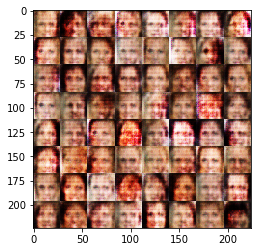

Epoch 1/1... Discriminator Loss: 0.4465... Generator Loss: 2.0921
Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 1.6081
Epoch 1/1... Discriminator Loss: 0.4682... Generator Loss: 2.5439
Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 2.4649
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 2.1559
Epoch 1/1... Discriminator Loss: 0.5608... Generator Loss: 1.9412
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 1.5844
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 2.3705
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 1.9722


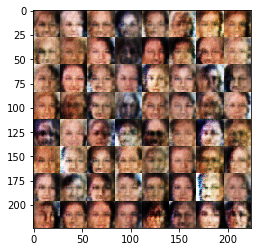

Epoch 1/1... Discriminator Loss: 0.5673... Generator Loss: 1.4126
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 2.9618
Epoch 1/1... Discriminator Loss: 0.6686... Generator Loss: 1.1633
Epoch 1/1... Discriminator Loss: 0.5355... Generator Loss: 1.7567
Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 1.3089
Epoch 1/1... Discriminator Loss: 0.5372... Generator Loss: 1.9229
Epoch 1/1... Discriminator Loss: 0.8182... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 0.6873... Generator Loss: 2.6499
Epoch 1/1... Discriminator Loss: 0.6475... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.0944


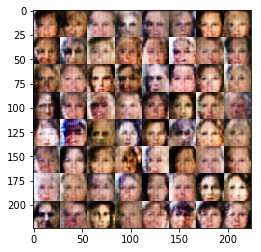

Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 1.8603
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 2.4124
Epoch 1/1... Discriminator Loss: 0.5776... Generator Loss: 1.9857
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 2.7448
Epoch 1/1... Discriminator Loss: 0.4662... Generator Loss: 1.9945
Epoch 1/1... Discriminator Loss: 0.6044... Generator Loss: 1.5064
Epoch 1/1... Discriminator Loss: 0.6044... Generator Loss: 1.8236
Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 1.6704
Epoch 1/1... Discriminator Loss: 0.6493... Generator Loss: 1.3975
Epoch 1/1... Discriminator Loss: 0.5554... Generator Loss: 2.5006


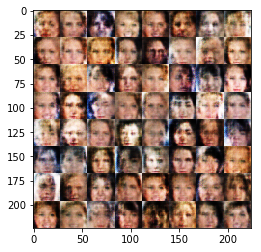

Epoch 1/1... Discriminator Loss: 0.6348... Generator Loss: 1.3630
Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 2.1923
Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 1.6278
Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 0.4940... Generator Loss: 2.1721
Epoch 1/1... Discriminator Loss: 0.6293... Generator Loss: 2.6404
Epoch 1/1... Discriminator Loss: 0.7366... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 0.5725... Generator Loss: 2.0367
Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 1.6251


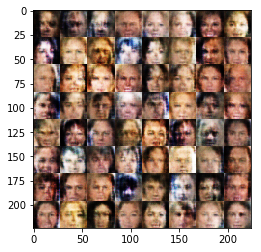

Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.0488
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 2.1139
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 1.4087
Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 2.0424
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 3.0378
Epoch 1/1... Discriminator Loss: 0.4587... Generator Loss: 1.7322
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 1.4244
Epoch 1/1... Discriminator Loss: 0.4668... Generator Loss: 1.6904
Epoch 1/1... Discriminator Loss: 0.5043... Generator Loss: 1.8801


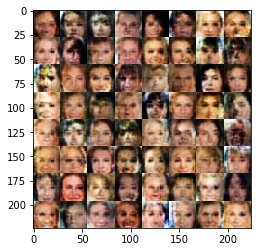

Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 0.6166... Generator Loss: 1.3230
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 2.1749
Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 0.5539... Generator Loss: 1.4337
Epoch 1/1... Discriminator Loss: 0.7455... Generator Loss: 3.3105
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 0.7223... Generator Loss: 1.4024


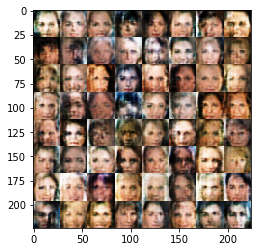

Epoch 1/1... Discriminator Loss: 0.5106... Generator Loss: 1.3569
Epoch 1/1... Discriminator Loss: 0.6222... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 0.4779... Generator Loss: 1.4449
Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 3.7233
Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 1.4027
Epoch 1/1... Discriminator Loss: 0.6144... Generator Loss: 2.8821
Epoch 1/1... Discriminator Loss: 0.5768... Generator Loss: 1.3694
Epoch 1/1... Discriminator Loss: 0.5170... Generator Loss: 1.6918
Epoch 1/1... Discriminator Loss: 0.5887... Generator Loss: 1.1340
Epoch 1/1... Discriminator Loss: 0.5898... Generator Loss: 2.4350


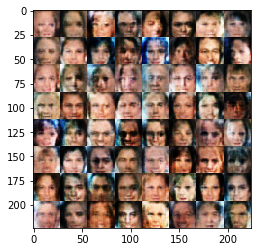

Epoch 1/1... Discriminator Loss: 0.6598... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 0.6092... Generator Loss: 1.5770
Epoch 1/1... Discriminator Loss: 0.6077... Generator Loss: 1.6887
Epoch 1/1... Discriminator Loss: 0.6649... Generator Loss: 2.0606
Epoch 1/1... Discriminator Loss: 0.6615... Generator Loss: 2.3559
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 0.6650... Generator Loss: 1.1262
Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 1.5819
Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 1.3644
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.6255


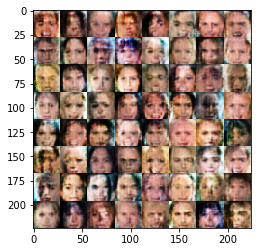

Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 1.9933
Epoch 1/1... Discriminator Loss: 0.6326... Generator Loss: 1.8922
Epoch 1/1... Discriminator Loss: 0.6987... Generator Loss: 2.4868
Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 2.4307
Epoch 1/1... Discriminator Loss: 0.5482... Generator Loss: 2.4223
Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 1.2972
Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 1.5768
Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 1.3704
Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 1.3442


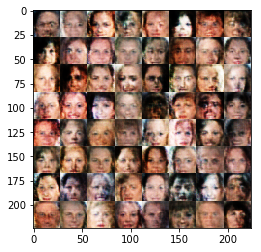

Epoch 1/1... Discriminator Loss: 0.5082... Generator Loss: 2.0952
Epoch 1/1... Discriminator Loss: 0.8443... Generator Loss: 2.5375
Epoch 1/1... Discriminator Loss: 0.4238... Generator Loss: 1.8164
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 1.4907
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.3649
Epoch 1/1... Discriminator Loss: 0.5433... Generator Loss: 1.7336
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 2.9318
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.3859
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 2.7375
Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 1.4478


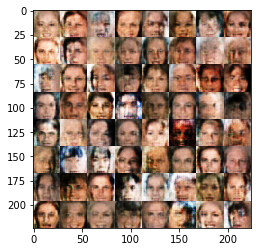

Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 1.4269
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 1.7551
Epoch 1/1... Discriminator Loss: 0.8714... Generator Loss: 2.3432
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 0.5798... Generator Loss: 1.6982
Epoch 1/1... Discriminator Loss: 0.4322... Generator Loss: 1.5616
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 1.1128
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 0.7323


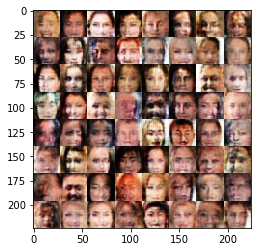

Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.4062
Epoch 1/1... Discriminator Loss: 0.4437... Generator Loss: 1.8433
Epoch 1/1... Discriminator Loss: 0.5464... Generator Loss: 1.3396
Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 1.7401
Epoch 1/1... Discriminator Loss: 0.4018... Generator Loss: 2.1384
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 1.8125
Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 0.6670... Generator Loss: 1.3154
Epoch 1/1... Discriminator Loss: 0.6217... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 0.3817... Generator Loss: 2.0949


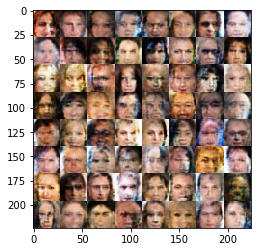

Epoch 1/1... Discriminator Loss: 0.6959... Generator Loss: 1.4347
Epoch 1/1... Discriminator Loss: 0.7217... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 0.4475... Generator Loss: 1.5427
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 0.8096... Generator Loss: 1.3235
Epoch 1/1... Discriminator Loss: 0.6969... Generator Loss: 1.4823
Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 0.7147... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 0.4907... Generator Loss: 2.2658


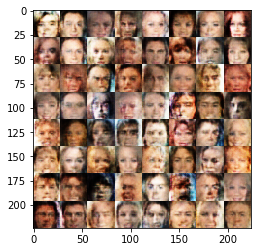

Epoch 1/1... Discriminator Loss: 0.6863... Generator Loss: 2.0473
Epoch 1/1... Discriminator Loss: 0.6289... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 1.4546
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 1.8746
Epoch 1/1... Discriminator Loss: 0.7031... Generator Loss: 2.0822
Epoch 1/1... Discriminator Loss: 0.4438... Generator Loss: 1.6724
Epoch 1/1... Discriminator Loss: 0.8803... Generator Loss: 0.9255
Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 0.4209... Generator Loss: 2.2822
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 3.9357


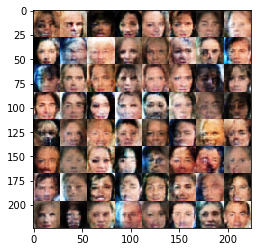

Epoch 1/1... Discriminator Loss: 0.6368... Generator Loss: 1.8199
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.5166
Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 1.1933
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 0.5589... Generator Loss: 1.2468
Epoch 1/1... Discriminator Loss: 0.4393... Generator Loss: 2.3250
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 1.9137
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 1.2203
Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 1.2603


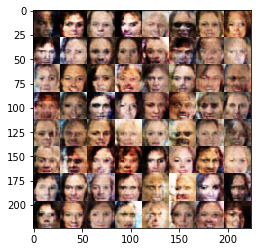

Epoch 1/1... Discriminator Loss: 0.5139... Generator Loss: 1.3828
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 3.6064
Epoch 1/1... Discriminator Loss: 0.4700... Generator Loss: 1.7935
Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 2.1992
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 0.6934... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 1.9943
Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 1.1654
Epoch 1/1... Discriminator Loss: 0.6648... Generator Loss: 1.2489


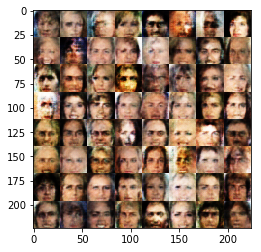

Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 1.4979
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 1.6046
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 0.6752... Generator Loss: 1.1982
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 1.3589
Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 2.1172
Epoch 1/1... Discriminator Loss: 0.5083... Generator Loss: 1.6491
Epoch 1/1... Discriminator Loss: 0.5403... Generator Loss: 1.6061
Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 0.8614


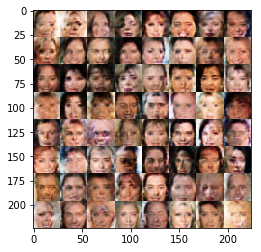

Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 2.2044
Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.4393
Epoch 1/1... Discriminator Loss: 0.7714... Generator Loss: 2.9218
Epoch 1/1... Discriminator Loss: 0.7562... Generator Loss: 1.2018
Epoch 1/1... Discriminator Loss: 0.6074... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 2.7046
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.0626
Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 1.7819
Epoch 1/1... Discriminator Loss: 0.7638... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 1.7012


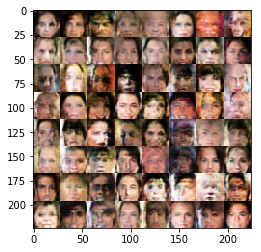

Epoch 1/1... Discriminator Loss: 0.6216... Generator Loss: 1.6200
Epoch 1/1... Discriminator Loss: 0.5853... Generator Loss: 1.5518
Epoch 1/1... Discriminator Loss: 0.7094... Generator Loss: 1.6873
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 1.8532
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 1.0755
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 0.5584... Generator Loss: 2.2627
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 0.4254... Generator Loss: 2.0826


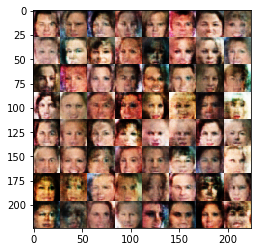

Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 1.8971
Epoch 1/1... Discriminator Loss: 0.6635... Generator Loss: 2.5187
Epoch 1/1... Discriminator Loss: 0.3814... Generator Loss: 1.7598
Epoch 1/1... Discriminator Loss: 0.7390... Generator Loss: 0.9839
Epoch 1/1... Discriminator Loss: 0.5713... Generator Loss: 1.9883
Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 1.8222
Epoch 1/1... Discriminator Loss: 0.6617... Generator Loss: 1.4869
Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 1.9702
Epoch 1/1... Discriminator Loss: 0.6926... Generator Loss: 1.9332
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 2.4707


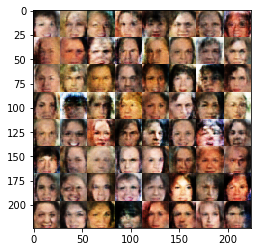

Epoch 1/1... Discriminator Loss: 0.6576... Generator Loss: 1.1402
Epoch 1/1... Discriminator Loss: 0.3603... Generator Loss: 2.1118
Epoch 1/1... Discriminator Loss: 0.8744... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 0.5998... Generator Loss: 1.2006
Epoch 1/1... Discriminator Loss: 0.5871... Generator Loss: 1.6399
Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 1.7559
Epoch 1/1... Discriminator Loss: 0.4372... Generator Loss: 1.5933
Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 1.7565
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 2.0923
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 0.8069


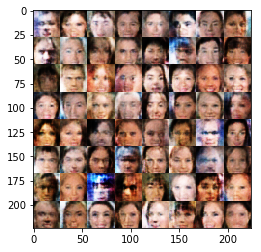

Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 1.8267
Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 1.3493
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 1.2697
Epoch 1/1... Discriminator Loss: 0.7736... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 1.6046
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 1.4818
Epoch 1/1... Discriminator Loss: 0.3505... Generator Loss: 2.6916
Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 0.9515
Epoch 1/1... Discriminator Loss: 0.8582... Generator Loss: 0.7751


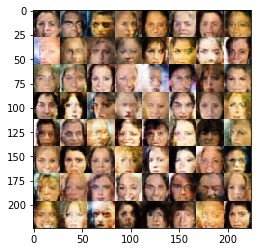

Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 1.2143
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 0.5497... Generator Loss: 1.6563
Epoch 1/1... Discriminator Loss: 0.4901... Generator Loss: 1.9501
Epoch 1/1... Discriminator Loss: 0.5707... Generator Loss: 1.5062
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.6032


In [36]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.